# Setting up

## Importing libraries, packages, data and functions

In [2]:
# Importing libraries
import random
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime
import pycountry_convert as pc

# Importing the data
data = pd.read_csv('customer_information.csv')

# Function to see the number of counts in each unique category
def plot_column_counts_with_annotations(data, column_name):
    # Counting unique values in the specified column
    counts = data[column_name].value_counts()

    # Plotting the counts as a bar graph
    ax = counts.plot(kind='bar')
    plt.xlabel(column_name)
    plt.ylabel("Counts")
    plt.title(f"Distribution of {column_name}")
    plt.xticks(rotation=45)

    # Annotating the bar graph with the counts
    for i, count in enumerate(counts):
        ax.annotate(str(count), (i, count), ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

    plt.show()

# Anonymising names into sampleID

In [3]:
def generate_sample_id(index):
    return f"sid_{str(index + 1).zfill(5)}"

data['sample_ID'] = data.index.to_series().apply(generate_sample_id)

# Banding birth year

                    min   max
birth_year_ranges            
1955-1967          1955  1967
1968-1979          1968  1979
1980-1990          1980  1990
1991-2003          1991  2003


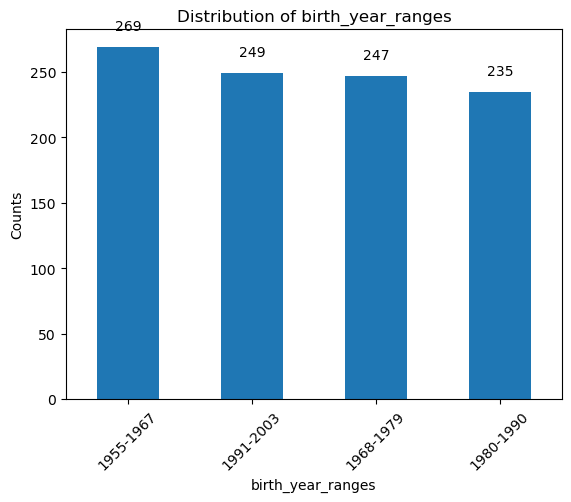

In [5]:
# Converting birth date to birth year
birthDate = pd.to_datetime(data.birthdate, format='mixed')
data['birth_year'] = pd.DatetimeIndex(birthDate).year

# Looking at min and max of birth year
min_birthyear = data['birth_year'].min() # 1955
max_birthyear = data['birth_year'].max() # 2003

# Assuming you have already created 'birth_year_group'
group_labels = ['1955-1967', '1968-1979', '1980-1990', '1991-2003']
data['birth_year_ranges'] = pd.qcut(data['birth_year'], 4, labels=group_labels)

# Group by the 'birth_year_group' and then find min and max of 'birth year' in each group
group_ranges = data.groupby('birth_year_ranges')['birth_year'].agg(['min', 'max'])

print(group_ranges)


# # Creating groups with 15 years range
# birthyear_bins = ["1955", "1975", "1995", "2003"]
# birthyear_labels = ["1955-1975", "1975-1995", "1995-2003"]

# # Banding heights into specified ranges
# data['birth_year_ranges'] = pd.cut(data['birth_year'], bins=birthyear_bins, labels=birthyear_labels, right=False)

# Showing counts of height ranges
plot_column_counts_with_annotations(data, 'birth_year_ranges')


# Banding country of birth to continent of birth

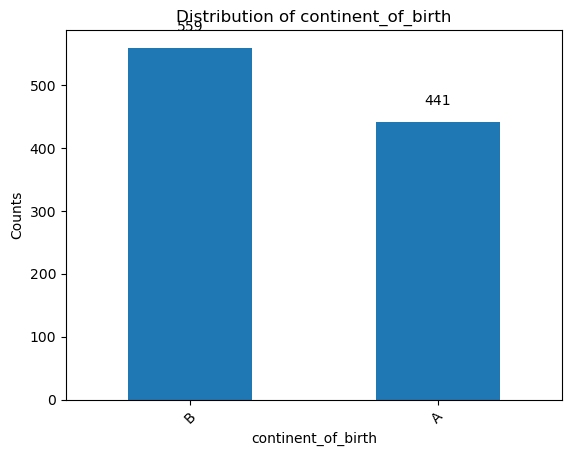

In [30]:
# Dictionary to manually map countries that could not be mapped via pycountry_convert
continent_mapping = {
    'Korea': 'Asia',
    'Western Sahara': 'Africa',
    'Slovakia (Slovak Republic)': 'Europe',
    'Saint Barthelemy': 'North America',
    'Pitcairn Islands': 'Oceania',
    'Holy See': 'Europe',
    'Reunion': 'Africa',
    'United States Minor Outlying Islands': 'North America',
    'Antarctica (the territory South of 60 deg S)': 'Antarctica',
    'Svalbard & Jan Mayen Islands': 'Europe',
    'Bouvet Island (Bouvetoya)': 'Antarctica',
    'Saint Helena': 'Africa',
    "Cote d'Ivoire": 'Africa',
    'British Indian Ocean Territory (Chagos Archipelago)': 'Asia',
    'Palestinian Territory': 'Asia',
    'Libyan Arab Jamahiriya': 'Africa',
    'Timor-Leste': 'Asia',
    'Netherlands Antilles': 'North America',
    'Holy See (Vatican City State)': 'Europe'
}

# Function to map country to continent
def country_to_continent(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        if country_name in continent_mapping:
            return continent_mapping[country_name]
        else:
            return 'Unknown'
        
# Applying the function to map the country to continent
data['continent_of_birth'] = data['country_of_birth'].apply(country_to_continent)

# # # Grouping Americas together and antarctica to oceania
data['continent_of_birth'].replace('Europe', 'A', inplace = True) # 228
data['continent_of_birth'].replace('North America', 'A', inplace = True) # 147
data['continent_of_birth'].replace('Asia', 'B', inplace = True) # 206
data['continent_of_birth'].replace('Oceania', 'B', inplace = True) # 117
data['continent_of_birth'].replace('South America', 'A', inplace = True) # 66
data['continent_of_birth'].replace('Africa', 'B', inplace = True) # 225
data['continent_of_birth'].replace('Antarctica', 'B', inplace = True) # 11

continent_labels = ["Europe & North America & Asia & Oceania", "South America & Africa & Antarctica"]

plot_column_counts_with_annotations(data, "continent_of_birth")

# Banding postcodes into regions

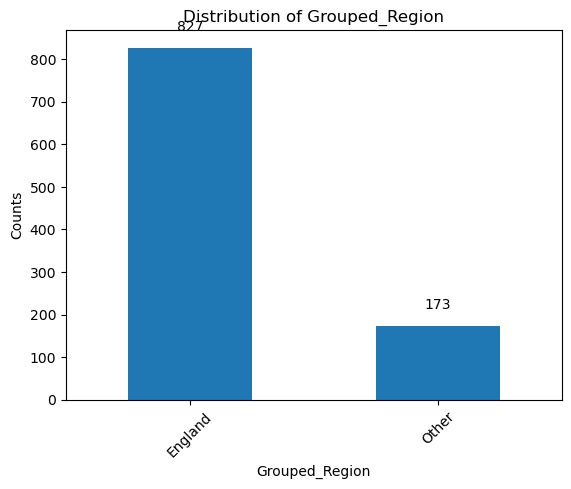

In [11]:
# Function to truncate postcode after the first numeric digit
def truncate_postcode(postcode):
    for i, char in enumerate(postcode):
        if char.isdigit():
            return postcode[:i]  # Truncate at the position of the first numeric digit
    return postcode  # Return the original postcode if no numeric digit is found

# Applying the function to create the postcode bands
data['postcode'] = data['postcode'].astype(str).apply(truncate_postcode)

# Importing postcode mapping to region
postcode_values = pd.read_excel('PostcodeRegions.xlsx')

# Making it into a dictionary
postcode_dict = postcode_values.set_index('Postcode Area')['Region'].to_dict()

# Applying the mapping to the dataframe
data['Region'] = data['postcode'].map(postcode_dict)

# Dictionary for mapping regions to 'England' or 'Other'
region_mapping = {
    'Greater London': 'England',
    'North West': 'England',
    'East Midlands': 'England',
    'West Midlands': 'England',
    'South East': 'England',
    'South West': 'England',
    'East of England': 'England',
    'North East': 'England',
    'East England': 'England',
    'Scotland': 'Other',
    'Wales': 'Other',
    'Channel Islands': 'Other',
    'Northern Ireland': 'Other',
    'Isle of Man': 'Other'
}

# Creating a new column with the mapped values
data['Grouped_Region'] = data['Region'].map(region_mapping)

plot_column_counts_with_annotations(data, 'Grouped_Region')

# Banding height and weight into BMI

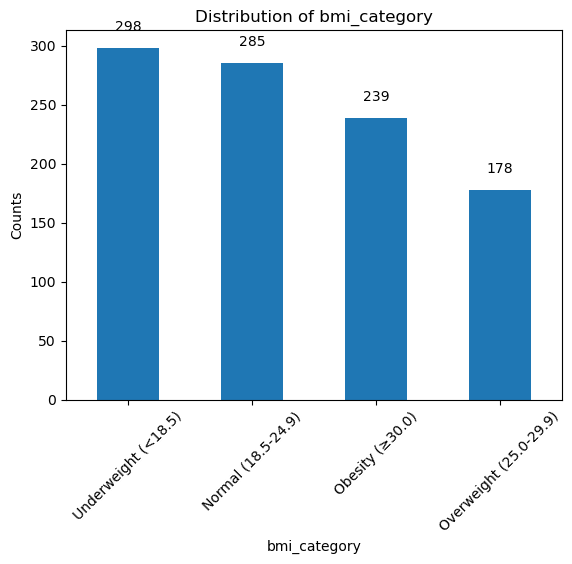

In [12]:
# Function to calculate BMI
def calculate_bmi(weight, height):
    return weight / (height ** 2)

# Calculate BMI for each row in the dataframe
data['bmi'] = data.apply(lambda row: calculate_bmi(row['weight'], row['height']), axis=1)

# Define BMI categories and their corresponding ranges
bmi_bins = [0, 18.5, 24.9, 29.9, float('inf')]  
bmi_labels = ['Underweight (<18.5)', 'Normal (18.5-24.9)', 'Overweight (25.0-29.9)', 'Obesity (≥30.0)']  

# Banding BMI into specified ranges
data['bmi_category'] = pd.cut(data['bmi'], bins=bmi_bins, labels=bmi_labels, right=False)

plot_column_counts_with_annotations(data, 'bmi_category')

# Banded education

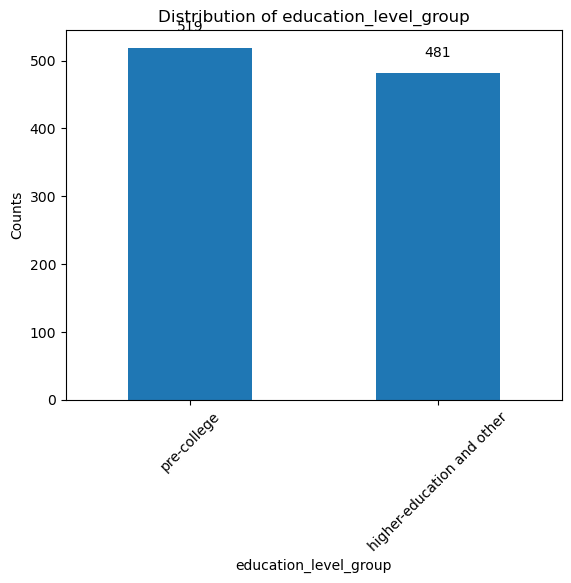

In [13]:
# Grouping Education level together
education_replacements = {
    'primary': 'pre-college',
    'secondary': 'pre-college',
    'bachelor': 'higher-education and other',
    'masters': 'higher-education and other',
    'phD': 'higher-education and other',
    'other': 'higher-education and other'
}

data['education_level_group'] = data['education_level'].map(education_replacements)

plot_column_counts_with_annotations(data, 'education_level_group')

# Generating final datasets

In [31]:
# Order of columns:
cols_gov = ['sample_ID', 'gender','birth_year_ranges', 'continent_of_birth', 'current_country', 'Grouped_Region', 'bmi_category', 'blood_group', 'avg_n_drinks_per_week', 'avg_n_cigret_per_week', 'education_level_group', 'n_countries_visited','cc_status']
cols_res = ['sample_ID', 'gender','birth_year', 'continent_of_birth', 'current_country', 'Region', 'weight', 'height', 'blood_group', 'avg_n_drinks_per_week', 'avg_n_cigret_per_week', 'education_level', 'n_countries_visited','cc_status']

In [32]:
# Generating final dataset for gov/public and researchers
final_data_gov = data[cols_gov]
final_data_res = data[cols_res]

# Exporting
final_data_gov.to_csv("final_ls_gv.csv", index=False)
final_data_res.to_csv("final_ls_res.csv", index=False)

# Calculating k-anonymity

In [33]:
test = pd.read_csv('final_ls_gv.csv')

In [35]:
quasi_identifiers_gov = ['gender', 'birth_year_ranges', 'continent_of_birth','education_level_group','Grouped_Region']
groups = test.groupby(quasi_identifiers_gov).size()
groups.min()
groups[groups==2]


gender  birth_year_ranges  continent_of_birth  education_level_group       Grouped_Region
F       1955-1967          B                   higher-education and other  Other             2
        1980-1990          A                   higher-education and other  Other             2
dtype: int64